In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [3]:
df=pd.read_csv("../../data/merged/len3_ship_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)
df["ship_date"]

C:\Users\hakos\AppData\Local\Temp\ipykernel_4232\1186495989.py:1: DtypeWarning: Columns (6,8,9,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../../data/merged/len3_ship_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)


0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4187    2022-08-31
4188    2022-09-30
4189    2022-10-31
4190    2022-11-30
4191    2022-12-31
Name: ship_date, Length: 4192, dtype: object

Estimation

In [4]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4187    0
4188    0
4189    0
4190    0
4191    0
Name: mon_1, Length: 4192, dtype: uint8

In [5]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [6]:
# change to the datetime format
df['ship_date'] = pd.to_datetime(df["ship_date"], format='%Y-%m-%d')
# df=df.set_index(["id","ship_date"])
df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1420 entries, (114, 2009) to (799, 2022)
Columns: 641 entries, month to year_trend
dtypes: datetime64[ns](1), float64(14), int32(3), int64(601), object(10), uint8(12)
memory usage: 6.8+ MB


(641, 14, 18)

In [7]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [8]:
before_p=10*12
after_p=15*12
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 0, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)


+elapsed_m120+elapsed_m119+elapsed_m118+elapsed_m117+elapsed_m116+elapsed_m115+elapsed_m114+elapsed_m113+elapsed_m112+elapsed_m111+elapsed_m110+elapsed_m109+elapsed_m108+elapsed_m107+elapsed_m106+elapsed_m105+elapsed_m104+elapsed_m103+elapsed_m102+elapsed_m101+elapsed_m100+elapsed_m99+elapsed_m98+elapsed_m97+elapsed_m96+elapsed_m95+elapsed_m94+elapsed_m93+elapsed_m92+elapsed_m91+elapsed_m90+elapsed_m89+elapsed_m88+elapsed_m87+elapsed_m86+elapsed_m85+elapsed_m84+elapsed_m83+elapsed_m82+elapsed_m81+elapsed_m80+elapsed_m79+elapsed_m78+elapsed_m77+elapsed_m76+elapsed_m75+elapsed_m74+elapsed_m73+elapsed_m72+elapsed_m71+elapsed_m70+elapsed_m69+elapsed_m68+elapsed_m67+elapsed_m66+elapsed_m65+elapsed_m64+elapsed_m63+elapsed_m62+elapsed_m61+elapsed_m60+elapsed_m59+elapsed_m58+elapsed_m57+elapsed_m56+elapsed_m55+elapsed_m54+elapsed_m53+elapsed_m52+elapsed_m51+elapsed_m50+elapsed_m49+elapsed_m48+elapsed_m47+elapsed_m46+elapsed_m45+elapsed_m44+elapsed_m43+elapsed_m42+elapsed_m41+elapsed_m40+elapse

                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elapsed_m120        -0.2406     0.1796    -1.3397     0.1806     -0.5930      0.1118
elapsed_m119        -0.3315     0.1774    -1.8693     0.0619     -0.6796      0.0165
elapsed_m118        -0.5918     0.3493    -1.6944     0.0905     -1.2772      0.0935
elapsed_m117        -0.4643     0.2782    -1.6693     0.0953     -1.0101      0.0815
elapsed_m116        -0.3605     0.1818    -1.9833     0.0476     -0.7172     -0.0038
elapsed_m115        -0.5120     0.2632    -1.9453     0.0520     -1.0285      0.0044
elapsed_m114        -0.7797     0.2264    -3.4442     0.0006     -1.2239     -0.3355
elapsed_m113         0.1869     0.2904     0.6435     0.5200     -0.3829      0.7567
elapsed_m112        -0.2473     0.2315    -1.0683     0.2856     

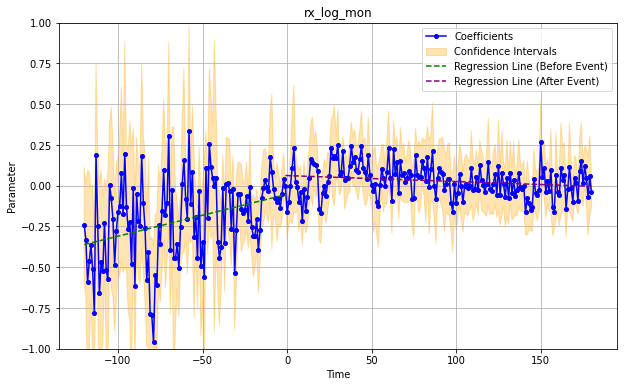

In [9]:
# take log
formula="log_rx_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon",title="rx_log_mon",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m120       -0.0596     0.5679    -0.1050     0.9164     -1.1739      1.0546
elapsed_m119       -0.5431     0.9465    -0.5738     0.5662     -2.4003      1.3141
elapsed_m118        0.6616     0.7835     0.8444     0.3986     -0.8758      2.1989
elapsed_m117       -0.6569     0.9218    -0.7127     0.4762     -2.4656      1.1518
elapsed_m116        0.2308     0.5228     0.4416     0.6589     -0.7949      1.2566
elapsed_m115       -1.2963     0.7120    -1.8207     0.0689     -2.6933      0.1007
elapsed_m114        1.4716     0.7726     1.9048     0.0571     -0.0443      2.9876
elapsed_m113        1.4222     0.9602     1.4812     0.1389     -0.4619      3.3063
elapsed_m112       -0.8813     0.8171    -1.0786     0.2810     -2.4845     

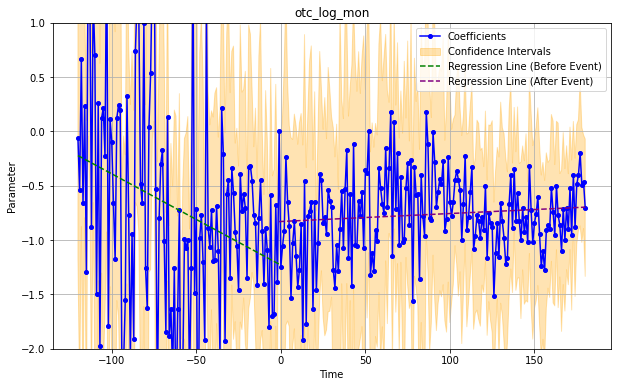

In [10]:
# take log

# till 20
# formula="log_otc_dom ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_otc_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon",title="otc_log_mon",ylim=(-2,1),plot_type="o-",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)